# **Project 2: Question Answering**
# **21CNTThuc - Nhóm 7**

Danh sách thành viên:

1.   Nguyễn Tuấn Anh - 21127216
2.   Nguyễn Hồng Quế Anh - 21127578
3.   Phan Huỳnh Tấn Đạt - 21127594
4.   Nguyễn Trọng Tín - 21127731
5.   Trần Công Bảo - 21127737



# **Import Libraries**

In [1]:
!pip install chardet
!pip install ftfy
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/54.4 kB ? eta -:--:--
   ------------------------------ --------- 41.0/54.4 kB 960.0 kB/s eta 0:00:01
   ---------------------------------------- 54.4/54.4 kB 940.3 kB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalling wcwidth-0.2.6:
      Successfully uninstalled wcwidth-0.2.6



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/297.6 kB ? eta -:--:--
   -------- ------------------------------- 61.4/297.6 kB 1.1 MB/s eta 0:00:01
   --------------------------- ------------ 204.8/297.6 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 297.6/297.6 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.28.0
    Uninstalling accelerate-0.28.0:
      Successfully uninstalled accelerate-0.28.0



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install underthesea


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import chardet
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
import torch
import codecs
from transformers import AutoTokenizer
wr.filterwarnings('ignore')

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f'mps available.')

else:
    print('No GPU/MPS available, using the CPU instead.')
    device = torch.device("cpu")

No GPU/MPS available, using the CPU instead.


#**Download Dataset**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import json
import pandas as pd

# Read the JSON file
def read_json_file(filename):
  with open(filename, 'r') as f:
    data = json.load(f)
    return data

# Read the JSON file
filename = '/content/drive/MyDrive/Colab/train.json'
data = read_json_file(filename)

if data is not None:
    # Shape of the data
    print("Number of records:", len(data))
    df = pd.DataFrame(data)
    print("Shape of data:", df.shape)
    print(df.head())

Number of records: 12000
Shape of data: (12000, 2)
                                             context  \
0  Về mặt kiến ​​trúc, trường có một nhân vật Côn...   
1  Tại hầu hết các trường đại học khác, sinh viên...   
2  Trường đại học là ghế chính của Tu Hội của Hol...   
3  Trường Cao đẳng Kỹ thuật được thành lập vào nă...   
4  Tất cả các sinh viên đại học Notre Dame là một...   

                                                 qas  
0  [{'id': '5733be284776f4190066117e', 'question'...  
1  [{'id': '5733bf84d058e614000b61bd', 'question'...  
2  [{'id': '5733bed24776f41900661188', 'question'...  
3  [{'id': '5733a6424776f41900660f4e', 'question'...  
4  [{'id': '5733a70c4776f41900660f62', 'question'...  


In [ ]:
import json
import pandas as pd
from underthesea import word_tokenize

def read_json_file(filename, special_chars_to_remove, remove_stopwords=False):
  with codecs.open(filename, 'r', errors='ignore') as f:
      data = json.load(f)
      # Combine basic, currency, math, formatting, and Vietnamese characters
      special_chars_to_remove = ''.join([
          # Basic punctuation
          '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=', '{', '}', '[', ']', '|', '\\', ';', ':', '\'', '"', ',', '.', '<', '>', '?', '~', '#',
          # Currency symbols (optional, uncomment if needed)
          '€', '£', '¥', '₩',
          # Mathematical symbols (optional, uncomment if needed)
          '÷', '×',
          # Formatting characters (optional, uncomment if needed)
          '\t', '\n', '\r',
          # Vietnamese characters (optional)
      ])

      # Remove special characters from strings within the JSON data
      def remove_chars(obj):
          if isinstance(obj, str):
              for char in special_chars_to_remove:
                  obj = obj.replace(char, '')
              # Optional: Remove stopwords using underthesea
              if remove_stopwords:
                  stopwords = load('/content/drive/MyDrive/Colab/vietnamese-stopwords.txt')  # Load stopwords from underthesea
                  words = word_tokenize(obj)  # Tokenize the text
                  obj = ' '.join([word for word in words if word not in stopwords])
          elif isinstance(obj, list):
              obj = [remove_chars(item) for item in obj]
          elif isinstance(obj, dict):
              for key, value in obj.items():
                  obj[key] = remove_chars(value)
          return obj

      data = remove_chars(data)
      return data

In [ ]:
def flatten_json(data):
  flattened_data = []
  for item in data:
      context = item['context']
      for qa in item['qas']:
          qa_dict = {
              'context': context,
              'id': qa['id'],
              'question': qa['question'],
              'answer_text': qa['answers'][0]['text'],
              'answer_start': qa['answers'][0]['answer_start'],
              'is_impossible': qa['is_impossible']
          }
          flattened_data.append(qa_dict)
  return flattened_data

# Optional: Remove stopwords using underthesea library
remove_stopwords = True

# Read the JSON file
file_path = '/content/drive/MyDrive/Colab/train.json'
data = read_json_file(file_path, remove_stopwords)

if data is not None:
  # Convert JSON to DataFrame (if data is valid)
  df = pd.DataFrame(data)
  # Flatten the JSON data
  flattened_data = flatten_json(data)
  df_flattened = pd.DataFrame(flattened_data)
  print("Shape of the flattened data:", df_flattened.shape)
  print(df_flattened.head())

Shape of the flattened data: (50046, 6)
                                             context  \
0  Về mặt kiến ​​trúc trường có một nhân vật Công...   
1  Về mặt kiến ​​trúc trường có một nhân vật Công...   
2  Về mặt kiến ​​trúc trường có một nhân vật Công...   
3  Về mặt kiến ​​trúc trường có một nhân vật Công...   
4  Về mặt kiến ​​trúc trường có một nhân vật Công...   

                         id  \
0  5733be284776f4190066117e   
1  5733be284776f4190066117f   
2  5733be284776f41900661180   
3  5733be284776f41900661181   
4  5733be284776f41900661182   

                                            question  \
0  Có gì ngồi trên đầu trang của Tòa nhà Chính tạ...   
1  là những gì ở phía trước của Notre Dame Tòa nh...   
2  Vương Cung Thánh Đường của trái tim Thánh tại ...   
3                    các Grotto tại Notre Dame là gì   
4  Mà đã bị cáo buộc Đức Trinh Nữ Maria xuất hiện...   

                             answer_text  answer_start  is_impossible  
0  bức tượng vàng của Đức T

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Show the shape of the dataset
print("Shape of the dataset:", df_flattened.shape)

Shape of the dataset: (50046, 8)


In [ ]:
# Calculate the number of questions and answers
num_questions = len(df_flattened)
num_answers = df_flattened['answer_text'].nunique()
print("Number of questions:", num_questions)
print("Number of unique answers:", num_answers)

Number of questions: 50046
Number of unique answers: 36038


In [ ]:
# Calculate the length of questions and answers
df_flattened['question_length'] = df_flattened['question'].apply(len)
df_flattened['answer_length'] = df_flattened['answer_text'].apply(len)

In [ ]:
# Calculate the ratio between True and False in the 'is_impossible' column
is_impossible_counts = df_flattened['is_impossible'].value_counts()
ratio_true_false = is_impossible_counts[False] / is_impossible_counts[False]
print("Ratio of True to False in 'is_impossible':", ratio_true_false)

Ratio of True to False in 'is_impossible': 1.0


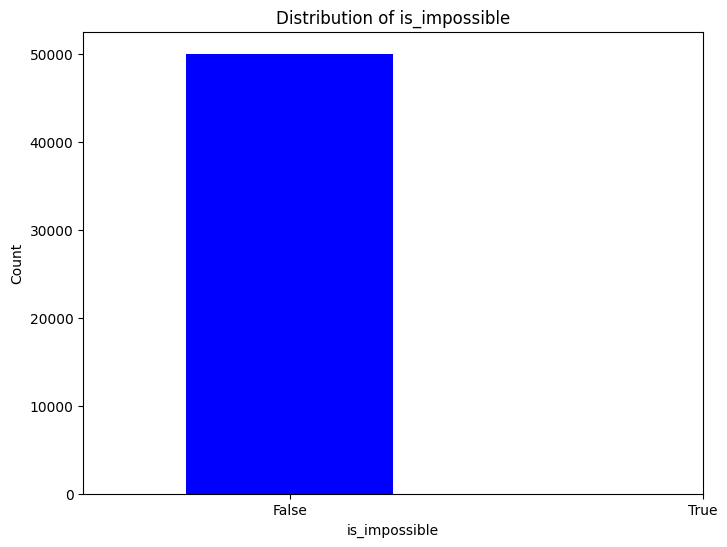

In [ ]:
# Create different types of charts for visualization
# Bar plot for is_impossible
plt.figure(figsize=(8, 6))
df_flattened['is_impossible'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of is_impossible')
plt.xlabel('is_impossible')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0)
plt.show()

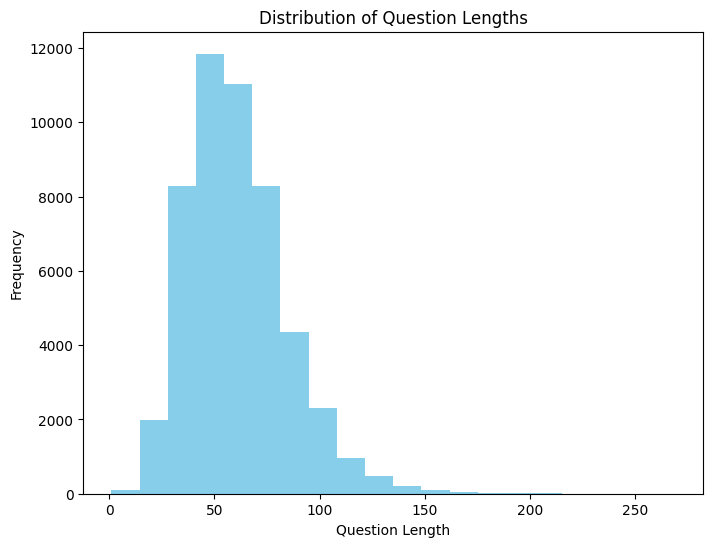

In [ ]:
# Histogram of question lengths
plt.figure(figsize=(8, 6))
plt.hist(df_flattened['question_length'], bins=20, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

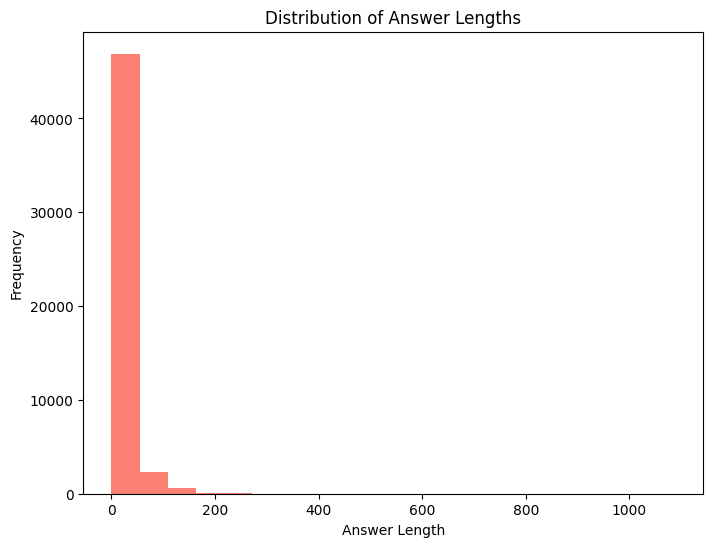

In [ ]:
# Histogram of answer lengths
plt.figure(figsize=(8, 6))
plt.hist(df_flattened['answer_length'], bins=20, color='salmon')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.describe()

,context,qas
count,12000,12000
unique,11999,11951
top,Catalan đã được thừa hưởng hệ thống nguyên âm ...,[]
freq,2,50


In [ ]:
df.columns.tolist()

['context', 'qas']

In [ ]:
df.isna().sum() #kiểm tra xem có dữ liệu null trong dataset hay không

context    0
qas        0
dtype: int64

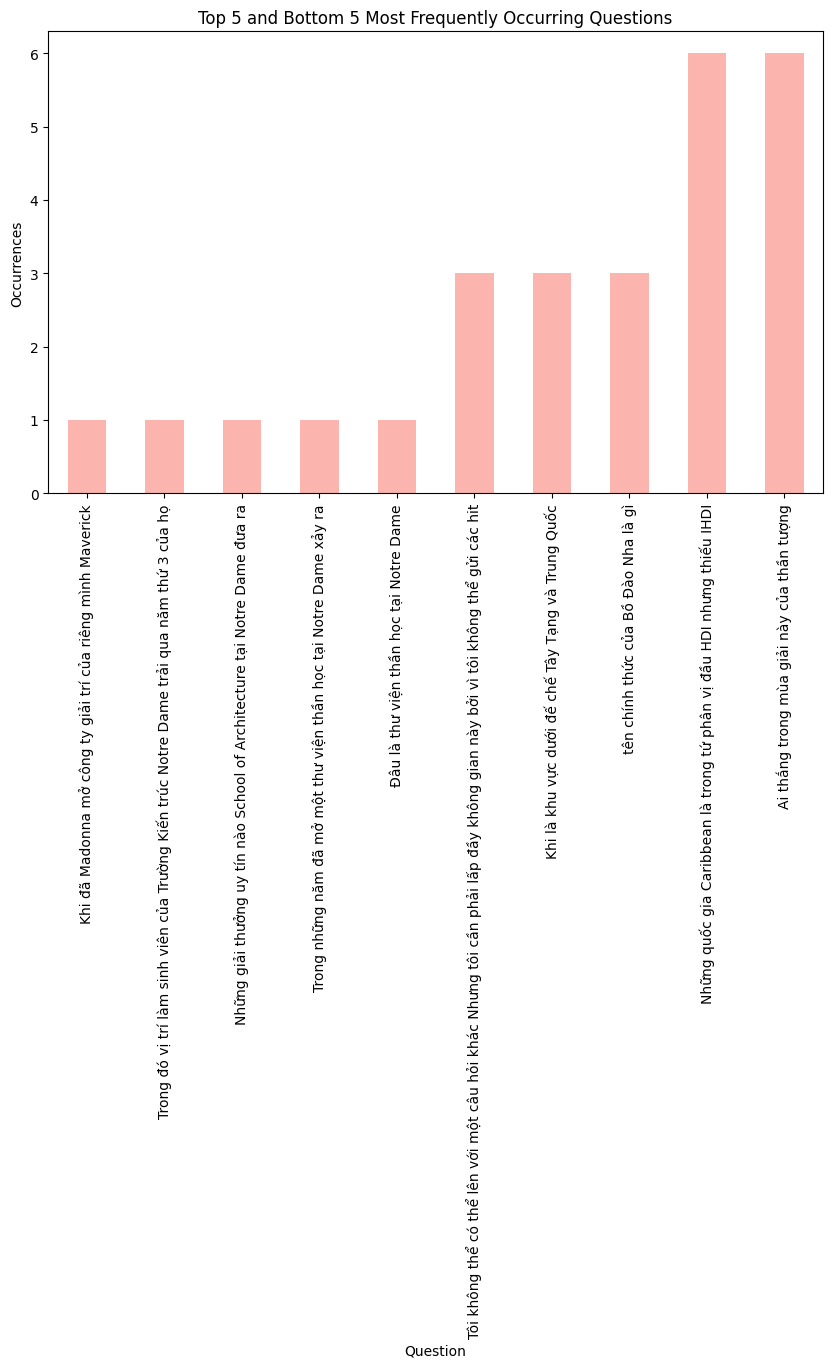

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each question
question_counts = df_flattened['question'].value_counts()

# Sort by occurrences
question_counts_sorted = question_counts.sort_values()

# Take only the 5 questions with the least occurrences and the 5 questions with the most occurrences
top_5_questions = question_counts_sorted.tail(5)
bottom_5_questions = question_counts_sorted.head(5)

# Concatenate for plotting
top_bottom_questions = pd.concat([bottom_5_questions, top_5_questions])

# Plot
plt.figure(figsize=(10, 6))
top_bottom_questions.plot(kind='bar')
plt.title('Top 5 and Bottom 5 Most Frequently Occurring Questions')
plt.xlabel('Question')
plt.ylabel('Occurrences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming df is your DataFrame containing the dataset
# Count the occurrences of each class in the 'is_impossible' column
class_counts = df_flattened['is_impossible'].value_counts()

# Find the minority class label (in this case, the 'True' label)
minority_label = class_counts.idxmin()

# Get the indices of samples with the minority class label
minority_indices = df[df_flattened['is_impossible'] == minority_label].index

# Calculate the difference in counts between the majority and minority classes
class_diff = class_counts.max() - class_counts.min()

# Randomly sample indices from the minority class with replacement to match the majority class
oversampled_indices = df.loc[minority_indices].sample(n=class_diff, replace=True).index

# Concatenate the original DataFrame with the oversampled DataFrame
oversampled_df = pd.concat([df, df.loc[oversampled_indices]])

# Shuffle the DataFrame to mix the original and oversampled data
oversampled_df = oversampled_df.sample(frac=1).reset_index(drop=True)

# Check the class distribution after oversampling
print(oversampled_df_flattened['is_impossible'].value_counts())


NameError: name 'oversampled_df_flattened' is not defined

# **EDA - Exploratory Data Analysis**

**Preprocess Dataset**

**Handling Imbalance**

# **Load Pretrained Model 1**

In [ ]:
import io
import os
from google.colab import drive
import pandas as pd
import numpy as np
import json
import sys

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"nhqanh","key":"67cf9f45d1a5c201386c417709e95663"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# https://technowhisp.com/kaggle-api-python-documentation/
# Authenticate to Kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('duyminhnguyentran/csc15105', unzip=True)

In [ ]:
file_path_train = "Project2_Data/train.json"
file_path_test = "Project2_Data/test.json"

In [ ]:
with open(file_path_train, 'r') as file:
    raw_train_data = json.load(file)
with open(file_path_train, 'r') as file:
    raw_test_data = json.load(file)

In [ ]:
df = pd.DataFrame(raw_train_data)

df.tail()

,context,qas
11995,"Năm 2008, Bloomberg tuyên bố lao động trẻ em t...","[{'id': '57279ecd4b864d19001638b8', 'question'..."
11996,"BBC, vào năm 2012, cáo buộc Glencore của việc ...","[{'id': '5727a0b22ca10214002d9252', 'question'..."
11997,Quy mô nhỏ khai thác tận thu của vàng là một n...,"[{'id': '5727a1343acd2414000de851', 'question'..."
11998,"Vào đầu tháng 8 năm 2008, Ủy Ban Lao Động Iowa...","[{'id': '5727a1a64b864d19001638e0', 'question'..."
11999,"Trong tháng 12 năm 2009, nhà vận động ở Anh kê...","[{'id': '5727a29e4b864d1900163900', 'question'..."


In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import AutoTokenizer

# Load pre-trained model tokenizer (vocabulary)
slow_tokenizer = AutoTokenizer.from_pretrained("timpal0l/mdeberta-v3-base-squad2")
save_path = "mdeberta_v3_base_squad2/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = AutoTokenizer.from_pretrained(save_path)
max_len = 384

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [ ]:
class SquadSample:
    def __init__(self, context, id, question, answer_text, answer_start, is_impossible):
        self.context = context
        self.id = id
        self.question = question
        self.answer_text = answer_text
        self.answer_start = answer_start
        self.is_impossible = is_impossible
        if self.answer_text is not None:
            self.end_idx = self.answer_start + len(self.answer_text)
        else:
            self.end_idx = None
        self.start_idx_token = self.answer_start
        self.end_idx_token = None
        self.offsets = None
        self.input_ids = None
        self.attention_mask = None
        self.token_type_ids = None
        self.validExample = True

    def preprocess(self):
        # Clean context, answer and question
        self.context = " ".join(str(self.context).split())
        self.question = " ".join(str(self.question).split())

        contextTokenizer = tokenizer.encode(self.context)

        if self.answer_text is not None: # in case we have an answer
            self.answer_text = " ".join(str(self.answer_text).split())
            # Calculate end_idx
            self.end_idx = self.answer_start + len(self.answer_text)
            if self.end_idx >= len(self.context):
                self.validExample = False
                return

            # Find characters of context that are part of answer
            is_part_of_answer = [0] * len(self.context)
            for i in range(self.answer_start, self.end_idx):
                is_part_of_answer[i] = 1

            # Find index of token that corresponds to start and the end of the answer
            answer_id_token = []
            for idx, (start, end) in enumerate(contextTokenizer.offsets):
                if sum(is_part_of_answer[start:end]) > 0:
                    answer_id_token.append(idx)
            # data to predict
            if len(answer_id_token) == 0:
                self.validExample = False
                return
            self.start_idx_token = answer_id_token[0]
            self.end_idx_token = answer_id_token[-1]
        self.offsets = contextTokenizer.offsets

        # Work on question
        questionTokenizer = tokenizer.encode(self.question)

        # Create model's inputs
        self.input_ids = contextTokenizer.ids + questionTokenizer.ids[1:]
        self.attention_mask = [1] * len(self.input_ids)
        self.token_type_ids = [0] * len(contextTokenizer.ids) + [1] * len(questionTokenizer.ids[1:])

        # Fix padding
        padding_length = max_len - len(self.input_ids)
        if padding_length > 0:
            self.input_ids = self.input_ids + ([0] * padding_length)
            self.attention_mask = self.attention_mask + ([0] * padding_length)
            self.token_type_ids = self.token_type_ids + ([0] * padding_length)
        elif padding_length < 0:
            self.validExample = False
            return


In [ ]:
def create_squad_examples(raw_data):
    squad_examples = []
    for index, row in raw_data.iterrows():
        context = row['context']
        question = row['question']
        answer_text = row['answer_text']
        answer_start = row['answer_start']
        is_impossible = row.get('is_impossible')  # Get the value of 'is_impossible', returns None if not found

        if not pd.isnull(answer_text):  # if answer is not null
            squad_eg = SquadSample(context, question, answer_text, None, answer_start, is_impossible)
        else:
            squad_eg = SquadSample(context, question, None, None, None, is_impossible)

        squad_eg.preprocess()
        squad_examples.append(squad_eg)

    return squad_examples


In [ ]:
def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids" : [],
        "attention_mask" : [],
        "token_type_ids" : [],
        "start_idx_token" : [],
        "end_idx_token" : []
    }
    for item in squad_examples:
        if item.validExample is True:
            dataset_dict["input_ids"].append(item.input_ids)
            dataset_dict["attention_mask"].append(item.attention_mask)
            dataset_dict["token_type_ids"].append(item.token_type_ids)
            dataset_dict["start_idx_token"].append(item.start_idx_token)
            dataset_dict["end_idx_token"].append(item.end_idx_token)

    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key], dtype=np.float16)

    x = [dataset_dict["input_ids"], dataset_dict["attention_mask"], dataset_dict["token_type_ids"]]
    y = [dataset_dict["start_idx_token"], dataset_dict["end_idx_token"]]

    return x, y


In [ ]:
with open(file_path_train, "r") as train_set:
    train_data = json.load(train_set)

with open(file_path_test, "r") as test_set:
    test_data = json.load(test_set)

data = train_data + test_data

with open('data.json', 'w', encoding='utf-8') as merged_file:
    json.dump(data, merged_file, ensure_ascii=False, indent=4)

df = pd.DataFrame(data)

In [ ]:
def extract_qas_features(df):
  qas_data = df['qas'].tolist()
  features_list = []

  for k, sample in enumerate(qas_data):
    qas_len = len(sample)
    context = df['context'][k]
    for i in range(qas_len):
      id = sample[i]['id']
      question = sample[i]['question']
      anwser_text = sample[i]['answers'][0]['text']
      answer_start = sample[i]['answers'][0]['answer_start']
      is_impossible = sample[i]['is_impossible']
      features_list.append(pd.Series([context, id, question, anwser_text, answer_start, is_impossible]))

  return pd.DataFrame(features_list)

In [ ]:
df = df[df['qas'].apply(lambda x: bool(x))]
df = df.reset_index(drop=True)

In [ ]:
df = extract_qas_features(df.copy())
df.columns = ['context','id', 'question', 'anwser_text', 'answer_start', 'is_impossible']

df['answer_length'] = df['anwser_text'].apply(len)
def mark_impossible(row):
    if row['answer_length'] == 0:
        return True
    else:
        return row['is_impossible']

df['is_impossible'] = df.apply(mark_impossible, axis=1)
df.head()

,context,id,question,anwser_text,answer_start,is_impossible,answer_length
0,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f4190066117e,Có gì ngồi trên đầu trang của Tòa nhà Chính tạ...,bức tượng vàng của Đức Trinh Nữ Maria,98,False,37
1,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f4190066117f,là những gì ở phía trước của Notre Dame Tòa nh...,một bức tượng đồng của Chúa Kitô,200,False,32
2,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f41900661180,Vương Cung Thánh Đường của trái tim Thánh tại ...,Tòa nhà Chính,304,False,13
3,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f41900661181,các Grotto tại Notre Dame là gì?,một nơi Marian cầu nguyện và suy,393,False,32
4,"Về mặt kiến ​​trúc, trường có một nhân vật Côn...",5733be284776f41900661182,Mà đã bị cáo buộc Đức Trinh Nữ Maria xuất hiện...,Saint Bernadette Soubirous,520,False,26


In [ ]:
import pandas as pd

# Assuming raw_train_data and raw_test_data are lists
# Convert them to DataFrames if they are not already
raw_train_df = pd.DataFrame(raw_train_data, columns=['context', 'id', 'question', 'answer_text', 'answer_start', 'is_impossible'])
raw_test_df = pd.DataFrame(raw_test_data, columns=['context', 'id', 'question', 'answer_text', 'answer_start', 'is_impossible'])

# Create training data
train_datas = create_squad_examples(raw_train_df)

# Create data
test_datas = create_squad_examples(raw_test_df)


AttributeError: 'list' object has no attribute 'offsets'

In [ ]:
train_data = pd.DataFrame.from_records([vars(line) for line in train_datas])
train_data[["context","question","answer_text"]].head()

In [ ]:
x_train, y_train = create_inputs_targets(train_datas)  # split the training data to input and target

x_test, y_test = create_inputs_targets(test_datas)  # split the  data to input and target

In [ ]:
doc_stride = 64
max_seq_length = 128
max_query_length = 32
batch_size = 16

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert to Tensors and build dataset
train_data = TensorDataset(torch.tensor(x_train[0], dtype=torch.int64),
                           torch.tensor(x_train[1], dtype=torch.float),
                           torch.tensor(x_train[2], dtype=torch.int64),
                           torch.tensor(y_train[0], dtype=torch.int64),
                           torch.tensor(y_train[1], dtype=torch.int64))

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
# Convert to Tensors and build dataset
train_sampler = RandomSampler(train_data)
train_data_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
eval_data = TensorDataset(torch.tensor(x_test[0], dtype=torch.int64),
                          torch.tensor(x_test[1], dtype=torch.float),
                          torch.tensor(x_test[2], dtype=torch.int64),
                          torch.tensor(y_test[0], dtype=torch.int64),
                          torch.tensor(y_test[1], dtype=torch.int64))

eval_sampler = SequentialSampler(eval_data)
validation_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=batch_size)

In [ ]:
import torch
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
    device = 'cuda'
else:
    print('No GPU available, training on CPU.')
    device = 'cpu'

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("timpal0l/mdeberta-v3-base-squad2")
param_optimizer = list(model.named_parameters())

In [ ]:
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.Adam(lr=1e-5, betas=(0.9, 0.98), eps=1e-9, params=optimizer_grouped_parameters)

In [ ]:
import string
import re

def normalize_text(text):
    text = text.lower()
    text = "".join(ch for ch in text if ch not in set(string.punctuation))
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)
    text = " ".join(text.split())
    return text

In [ ]:
epochs = 5

for epoch in range(1, epochs + 1):
    # ============================================ TRAINING ============================================================
    print("Training epoch ", str(epoch))

    model.train()
    tr_loss = 0
    nb_tr_steps = 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)

        inputs = {'input_ids':       batch[0],
                  'attention_mask':  batch[1],
                  'token_type_ids':  batch[2],
                  'start_positions': batch[3],
                  'end_positions':   batch[4]}

        optimizer.zero_grad()

        outputs = model(**inputs)
        loss = outputs[0]

        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        nb_tr_steps += 1

    print(f"\nTraining loss={tr_loss / nb_tr_steps:.4f}")

    # ============================================ VALIDATION ==========================================================
    model.eval()
    currect_query = 0
    correct_ans = 0
    valid_examples = [x for x in test_datas if x.validExample is True]
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)

        input_ids, attention_mask, token_type_ids, start_positions, end_positions = batch

        with torch.no_grad():
          start_logits, end_logits =  model(input_ids=input_ids,
                                              attention_mask=attention_mask,
                                              token_type_ids=token_type_ids, return_dict=False)

          pred_start, pred_end = start_logits.detach().cpu().numpy(), end_logits.detach().cpu().numpy()

        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = valid_examples[currect_query]
            currect_query += 1
            offsets = squad_eg.offsets
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]
            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(x) for x in squad_eg.more_answers]
            if normalized_pred_ans in normalized_true_ans:
                correct_ans += 1
    acc = correct_ans / len(y_test[0])

    print(f"\nAccuracy score={acc:.2f}\n")
    print("-----------------------------------------")

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")


**Fine-tuning the Model based on Project Dataset**


In [ ]:
from datasets import load_metric

squad_metric = load_metric("squad")

def compute_metrics(eval_predictions):
    predictions, references = eval_predictions
    return squad_metric.compute(predictions=predictions, references=references)["f1"]

In [ ]:
from transformers import Trainer, AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained("timpal0l/mdeberta-v3-base-squad2")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=test,
    compute_metrics=compute_metrics,
)

trainer.train()

**Evaluate the trained model**

**Generate Answer**

# **Load Pretrained Model 2**

**Read Dataset**

In [7]:
!pip install --upgrade accelerate transformers torch
!pip install torchdynamo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for torchdynamo
  Running setup.py clean for torchdynamo
Failed to build torchdynamo
ERROR: Could not build wheels for torchdynamo, which is required to install pyproject.toml-based projects


In [8]:
# Load the dataset file
with open("/content/drive/MyDrive/Project2_Data/train.json", 'r', encoding='utf-8') as f:
    df = json.load(f)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Project2_Data/train.json'

In [6]:
with open("/content/drive/MyDrive/Project2_Data/test.json", 'r', encoding='utf-8') as f:
    test_data = json.load(f)

In [7]:
import json
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, Seq2SeqTrainer, Seq2SeqTrainingArguments


**Tokenizer** - Convert the input to fit the model

In [8]:
# Load the tokenizer for VietAI/vit5-base
tokenizer = T5Tokenizer.from_pretrained("VietAI/vit5-base")

# Prepare the dataset
def prepare_dataset(data):
    context = data['context']
    qas = data['qas']

    # List to hold prepared samples
    prepared_samples = []

    for qa in qas:
        # Combine context and question text
        input_text = f"{context} {qa['question']}"
        answer_text = qa['answers'][0]['text']  # Get first answer text

        # Tokenize the input text
        inputs = tokenizer(input_text, padding='max_length', truncation=True, return_tensors='pt', max_length=512)
        # Tokenize the answer text
        labels = tokenizer(answer_text, padding='max_length', truncation=True, return_tensors='pt', max_length=128)

        # Prepare the sample
        prepared_sample = {
            'input_ids': inputs['input_ids'].squeeze(),  # Squeeze tensors to remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels['input_ids'].squeeze(),
        }

        prepared_samples.append(prepared_sample)

    return prepared_samples


train_dataset = [sample for data in df for sample in prepare_dataset(data)]
eval_dataset = [sample for data in test_data for sample in prepare_dataset(data)]



tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


**Fine-tuning the Model based on Project Dataset**

In [ ]:
# Load the model
model = T5ForConditionalGeneration.from_pretrained('vietAI/vit5-base')

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,
    fp16=False, #True
)

# Define the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset

)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss


**Evaluate the trained model**

In [ ]:
# Evaluate the model using the evaluation dataset
evaluation_results = trainer.evaluate(eval_dataset=eval_dataset)

# Print evaluation results
print(evaluation_results)


**Generate Answer**

In [ ]:
def generate_answer(context, question):
    input_text = f'context: {context} question: {question}'
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    output_ids = model.generate(input_ids)
    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return answer

context = "Về mặt kiến ​​trúc, trường có một nhân vật Công giáo. Trên đỉnh mái vòm vàng tòa nhà của chính là bức tượng vàng của Đức Trinh Nữ Maria..."
question = "Có gì ngồi trên đầu trang của Tòa nhà Chính tại Notre Dame?"
print(generate_answer(context, question))


# **Comparison & Overview**